<a href="https://colab.research.google.com/github/cmwoodley/BART_LMWG_model/blob/update_models/notebooks/BART_LMWG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup - Run both cells sequentially

In [ ]:
#@title Set up requirements
#@markdown Run This cell to install required packages. Runtime approx 1 minutes.


!echo y | pip uninstall pymc
!pip install pymc3

!pip install -q condacolab
import condacolab
condacolab.install()
!conda install mkl-service
!pip install rdkit-pypi
!pip install scipy==1.7.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pymc3-3.11.5-py3-none-any.whl (872 kB)
  Using cached semver-3.0.0-py3-none-any.whl (17 kB)
  Using cached scipy-1.7.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached deprecat-2.1.1-py2.py3-none-any.whl (9.8 kB)
  Using cached numpy-1.22.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.6 MB/s eta 0:00:00
  Using cached Theano_PyMC-1.1.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.4 MB/s eta 0:00:00
  Using cached arviz-0.15.0-py3-none-any.whl (1.6 MB)
  Using cached arviz-0.14.0-py3-none-any.whl (1.7 MB)
  Using cache

✨🍰✨ Everything looks OK!
Solving environment: | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Build models
#@markdown Run This cell to build models ready for predictions. Runtime approx 4 minutes.


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error
from rdkit import Chem
from rdkit.Chem import AllChem
import pymc3 as pm
import arviz as az
from rdkit.Chem import Draw
import seaborn as sns
import matplotlib.pyplot as plt

## Helper Functions

def variance_threshold_selector(data, threshold=0.00):
	selector = VarianceThreshold(threshold)
	selector.fit(data)
	return data[data.columns[selector.get_support(indices=True)]]

def get_ci_error(model, x, y, pred, error):
    x_dist = model.μ.distribution.predict(np.array(x))
    x_reshape = x_dist.T
    ci = list(az.hdi(np.array(x), hxdi_prob=0.89) for x in x_reshape)
    ci_flat =np.stack(ci)
    ci_errors = (np.abs(ci_flat - pred.reshape(len(pred),1)))

    error_lim = np.log10(10**y+np.array(error).reshape(1,-1))-y


    return x_dist, ci, ci_errors, error_lim

def get_pred(model, x):
    x_dist = model.μ.distribution.predict(np.array(x))
    pred = x_dist.mean(axis=0)
    x_reshape = x_dist.T
    ci = list(az.hdi(np.array(x), hxdi_prob=0.89) for x in x_reshape)
    ci_flat =np.stack(ci)
    ci_errors = (np.abs(ci_flat - pred.reshape(len(pred),1)))

    return x_dist, pred, ci, ci_errors

xtrain_columns = ['num_rings', 'FCFP_5', 'FCFP_6', 'FCFP_8', 'FCFP_21', 'FCFP_25',
       'FCFP_46', 'FCFP_71', 'FCFP_147', 'FCFP_148', 'FCFP_224', 'FCFP_264',
       'FCFP_334', 'FCFP_403', 'FCFP_416', 'FCFP_428', 'FCFP_465', 'FCFP_468',
       'FCFP_532', 'FCFP_537', 'FCFP_543', 'FCFP_548', 'FCFP_598', 'FCFP_646',
       'FCFP_660', 'FCFP_718', 'FCFP_764', 'FCFP_789', 'FCFP_792', 'FCFP_806',
       'FCFP_927', 'FCFP_1063', 'FCFP_1085', 'FCFP_1092', 'FCFP_1157',
       'FCFP_1304', 'FCFP_1336', 'FCFP_1395', 'FCFP_1566', 'FCFP_1668',
       'FCFP_1706', 'FCFP_1727', 'FCFP_1797', 'FCFP_1849', 'FCFP_1907',
       'FCFP_1915', 'FCFP_2030', 'ECFP_114', 'ECFP_173', 'ECFP_507',
       'ECFP_598', 'ECFP_684', 'ECFP_728', 'ECFP_736', 'ECFP_989', 'ECFP_1039',
       'ECFP_1087', 'ECFP_1104', 'ECFP_1112', 'ECFP_1118', 'ECFP_1167',
       'ECFP_1187', 'ECFP_1357', 'ECFP_1410', 'ECFP_1460', 'ECFP_1517',
       'ECFP_1530', 'ECFP_1624', 'ECFP_1665', 'ECFP_1691', 'ECFP_1935',
       'ECFP_1977']

def predict_single(smiles, conc):
    '''Predicts LogG′ and LogG′′ from a smiles string at a given concentration.

    Takes SMILES string as a string, and concentration as an integer or a float'''

    assert type(smiles) == str
    assert type(conc) == float or type(conc) == int

    mol = Chem.MolFromSmiles(smiles)

    fcfp = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, useFeatures=True)
    Chem.DataStructs.ConvertToNumpyArray(fp, fcfp)

    ecfp = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, useFeatures=False)
    Chem.DataStructs.ConvertToNumpyArray(fp, ecfp)

    num_rings = np.array([Chem.rdMolDescriptors.CalcNumRings(mol)])

    cols = ["num_rings"] + ["FCFP_"+str(i) for i in range(2048)] + ["ECFP_"+str(i) for i in range(2048)]

    df = pd.DataFrame(np.concatenate([num_rings, fcfp, ecfp]), index=cols).T*conc
    df = pd.DataFrame(scaler.transform(df[xtrain_columns]), columns=xtrain_columns)

    g_dist, g_pred, gci, gci_errors = get_pred(model_g, df)
    gdbl_dist, gdbl_pred, gdblci, gdblci_errors = get_pred(model_gdbl, df)

    ## Plot Prediction Summary Graph

    fig = plt.figure(figsize=(14,6), layout="constrained")
    ax1 = plt.subplot(2,2,1)
    ax1.axis("off")
    ax1.imshow(Draw.MolToImage(mol, (500,400)))
    ax2 = plt.subplot(2,2,3)
    ax3 = plt.subplot(2,2,4)
    ax4 = plt.subplot(2,2,2)

    sns.kdeplot(g_dist, fill=True, label = "Distribution", ax = ax2, palette="viridis")
    ax2.axvline(g_pred,0,1, color="red", ls="--", label="Predicted Value")
    ax2.axvline(gci[0][0], 0,1, color="green", label="89% Bayesian CI")
    ax2.axvline(gci[0][1], 0,1, color="green")
    ax2.set_title("G′ Distribution",fontsize=20)
    ax2.set_xlabel("Predicted LogG′", fontsize=20)

    sns.kdeplot(gdbl_dist, fill=True, label = "Distribution", ax = ax3)
    ax3.axvline(gdbl_pred,0,1, color="red", ls="--", label="Predicted Value")
    ax3.axvline(gdblci[0][0], 0,1, color="green", label="89% Bayesian CI")
    ax3.axvline(gdblci[0][1], 0,1, color="green")
    ax3.set_title("G″ Distribution",fontsize=20)
    ax3.set_xlabel("Predicted LogG″", fontsize=20)

    for ax in [ax2,ax3]:
        ax.legend(fontsize=15, loc="upper left")
        ax.set_ylabel("Density", fontsize="20")
        ax.tick_params(axis='both', which='major', labelsize=15)


    for ax, pred in zip([ax2,ax3],[g_pred, gdbl_pred]):
        ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.7,ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.8, "Predicted Value:\n{}".format(np.round(pred,3)[0]), backgroundcolor="white", fontsize=15)

    ax1.set_title("Prediction Summary", fontsize=25)


    #report table

    results = pd.DataFrame([[g_pred[0], gdbl_pred[0]],[gci[0][0],gdblci[0][0]],[gci[0][1],gdblci[0][1]]],index=["Predicted Value","Lower CI","Upper CI"], columns=["Gprime","Gdblprime"]).T
    results["CI Range"] = results.iloc[:,2]-results.iloc[:,1]
    results

    ax4.axis("off")
    ax4.text(0.25,0.6,str(np.round(results.iloc[0,0],3)),fontsize=15)
    ax4.text(0.45,0.6,str(np.round(results.iloc[0,1],3)),fontsize=15)
    ax4.text(0.60,0.6,str(np.round(results.iloc[0,2],3)),fontsize=15)
    ax4.text(0.75,0.6,str(np.round(results.iloc[0,3],3)),fontsize=15)

    ax4.text(0.1,0.6,"LogG′",fontsize=15)
    ax4.text(0.25,0.75,"Predicted\nValue",fontsize=15)
    ax4.text(0.45,0.75,"Lower\nCI",fontsize=15)
    ax4.text(0.60,0.75,"Upper\nCI",fontsize=15)
    ax4.text(0.75,0.75,"CI\nRange",fontsize=15)

    ax4.text(0.1,0.45,"LogG″",fontsize=15)
    ax4.text(0.25,0.45,str(np.round(results.iloc[1,0],3)),fontsize=15)
    ax4.text(0.45,0.45,str(np.round(results.iloc[1,1],3)),fontsize=15)
    ax4.text(0.60,0.45,str(np.round(results.iloc[1,2],3)),fontsize=15)
    ax4.text(0.75,0.45,str(np.round(results.iloc[1,3],3)),fontsize=15)

    plt.show()

    return results

def predict_batch(smiles, conc):
    '''Predicts LogG′ and LogG′′ from a batch of smiles strings at given concentrations.

    Takes SMILES strings as list or 1D array, takes conc as list or 1D array'''

    conc = [float(x) for x in conc]

    mols = [Chem.MolFromSmiles(x) for x in smiles]

    num_rings = []
    fcfps = []
    ecfps = []
    for mol in mols:
        fcfp = np.zeros((1,))
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, useFeatures=True)
        Chem.DataStructs.ConvertToNumpyArray(fp, fcfp)
        fcfps.append(fcfp)

        ecfp = np.zeros((1,))
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, useFeatures=False)
        Chem.DataStructs.ConvertToNumpyArray(fp, ecfp)
        ecfps.append(ecfp)

        num_rings.append(np.array([Chem.rdMolDescriptors.CalcNumRings(mol)]))

    cols = ["num_rings"] + ["FCFP_"+str(i) for i in range(2048)] + ["ECFP_"+str(i) for i in range(2048)]

    num_rings = np.stack(num_rings)
    fcfps = np.stack(fcfps)
    ecfps = np.stack(ecfps)

    df = pd.DataFrame(np.concatenate([num_rings,fcfps,ecfps],axis=1), columns=cols)
    for col in df.columns:
        df[col] = df[col]*conc
    df = pd.DataFrame(scaler.transform(df[xtrain_columns]), columns=xtrain_columns)

    g_dist, g_pred, gci, gci_errors = get_pred(model_g, df)
    gdbl_dist, gdbl_pred, gdblci, gdblci_errors = get_pred(model_gdbl, df)

    gci = np.stack(gci)
    gdblci = np.stack(gdblci)

    results = pd.DataFrame([g_pred, gci[:,0], gci[:,1], gdbl_pred, gdblci[:,0], gdblci[:,1]], index=["G′ Predicted Value","G′ Lower CI","G′ Upper CI","G″ Predicted Value","G″ Lower CI","G″ Upper CI"]).T
    results ["G′ CI Range"] = results.iloc[:,2]-results.iloc[:,1]
    results ["G″ CI Range"] = results.iloc[:,5]-results.iloc[:,4]
    results["Smiles"] = smiles
    results["Conc"] = conc

    return results[["Smiles","G′ Predicted Value","G′ Lower CI","G′ Upper CI","G′ CI Range","G″ Predicted Value","G″ Lower CI","G″ Upper CI","G″ CI Range","Conc"]]

## Load in data

url = 'https://raw.githubusercontent.com/cmwoodley/BART_LMWG_model/master/data/raw/data.csv'

data = pd.read_csv(url)

train = np.where(data.label == "train")[0]
test = np.where(data.label == "test")[0]
val = np.where(data.label == "val")[0]

smiles_full = data.SMILES
mols_full = [Chem.MolFromSmiles(x) for x in smiles_full]
g = data.g
gdbl = data.gdbl

gtrain_error = data.err_g[train]
gtest_error = data.err_g[test]
gval_error = data.err_g[val]
gdbltrain_error = data.err_gdbl[train]
gdbltest_error = data.err_gdbl[test]
gdblval_error = data.err_gdbl[val]

## Get Descriptors

df = pd.DataFrame()
df["num_rings"] = [Chem.rdMolDescriptors.CalcNumRings(x) for x in mols_full]

fcfp = []
for mol in mols_full:
    ar = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, useFeatures=True)
    Chem.DataStructs.ConvertToNumpyArray(fp,ar)
    fcfp.append(ar)
fcfp = pd.DataFrame(np.stack(fcfp), columns=["FCFP_"+str(i) for i in range(2048)])
ecfp = []
for mol in mols_full:
    ar = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, useFeatures=False)
    Chem.DataStructs.ConvertToNumpyArray(fp,ar)
    ecfp.append(ar)
ecfp = pd.DataFrame(np.stack(ecfp), columns=["ECFP_"+str(i) for i in range(2048)])
df = pd.concat([df,fcfp,ecfp],axis=1)


for col in df.columns:
    df[col] = df[col]*data.conc

## Split into predetermined train, test and validation sets

xtrain = df.iloc[train]
xtest = df.iloc[test].reset_index(drop=True)
xval = df.iloc[val].reset_index(drop=True)

gtrain = g.iloc[train]
gtest = g.iloc[test]
gval = g.iloc[val]

gdbltrain = gdbl.iloc[train]
gdbltest = gdbl.iloc[test]
gdblval = gdbl.iloc[val]



## Remove correlated and zero variance descriptors

xtrain = variance_threshold_selector(xtrain)
corr_matrix = xtrain.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]+["FCFP_0"] ## Added FCFP_0 due to being set in all molecules
xtrain = xtrain.drop(xtrain[to_drop], axis=1)
xtest = xtest[xtrain.columns]
xval = xval[xtrain.columns]

scaler = StandardScaler()
xtrain = pd.DataFrame(scaler.fit_transform(xtrain), columns = xtrain.columns)
xtest = pd.DataFrame(scaler.transform(xtest), columns = xtrain.columns)
xval = pd.DataFrame(scaler.transform(xval), columns = xtrain.columns)

## BART requires y data as np array

gtrain = np.ravel(gtrain)
gtest = np.ravel(gtest)
gval = np.ravel(gval)

gdbltrain = np.ravel(gdbltrain)
gdbltest = np.ravel(gdbltest)
gdblval = np.ravel(gdblval)

## Build and save models

models = []
traces = []
for y,m,alpha in [(gtrain,10,0.9), (gdbltrain,25,0.8)]:
    with pm.Model() as model:
        σ = pm.HalfNormal('σ', 1)
        μ = pm.BART('μ', xtrain, np.array(y), m=m, alpha=alpha)
        y = pm.Normal('y', μ, σ, observed=np.array(y))
        trace = pm.sample(2000, cores=1, tune=1000, return_inferencedata=False, random_seed = 42)

    models.append(model)
    traces.append(trace)

model_g = models[0]
trace_g = traces[0]
model_gdbl = models[1]
trace_gdbl = traces[1]

The BART model is experimental. Use with caution.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 62 seconds.
The number of effective samples is smaller than 25% for some parameters.
The BART model is experimental. Use with caution.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 71 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Get Predictions

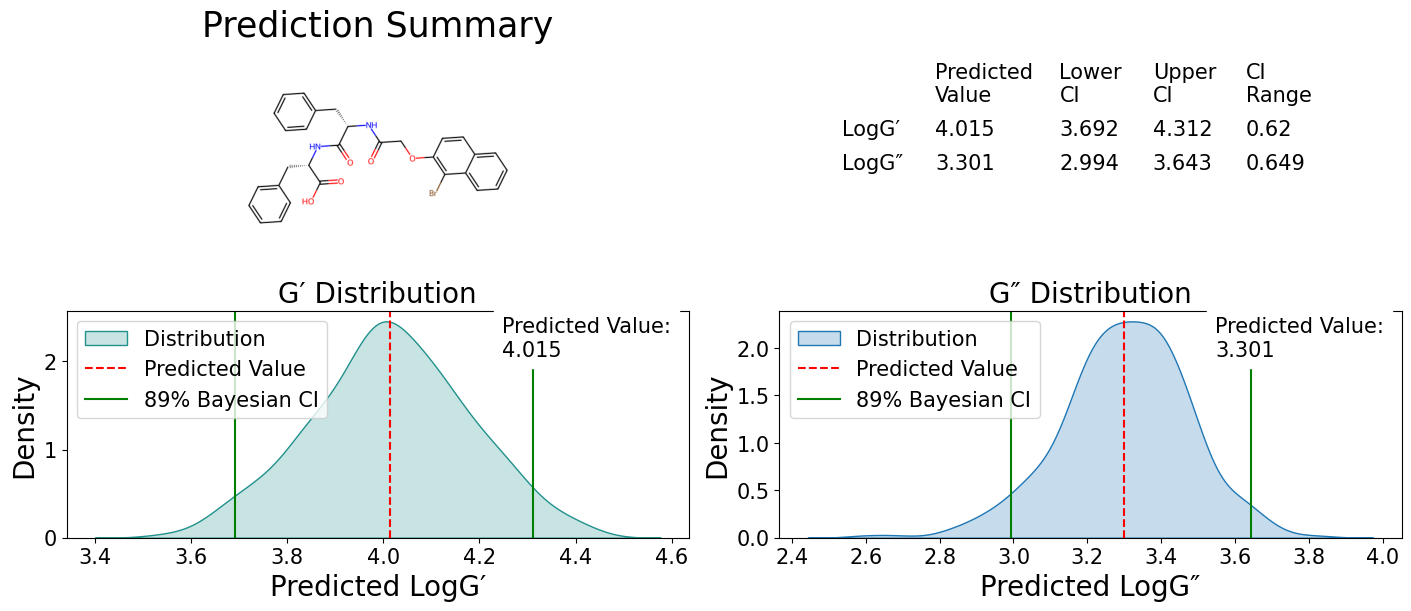

,Predicted Value,Lower CI,Upper CI,CI Range
Gprime,4.014725,3.692114,4.311641,0.619527
Gdblprime,3.300675,2.993667,3.642638,0.648971


In [ ]:
#@title Get Single Prediction

Smiles = 'O=C(N[C@@H](CC1=CC=CC=C1)C(N[C@@H](CC2=CC=CC=C2)C(O)=O)=O)COC3=C(Br)C4=CC=CC=C4C=C3' #@param {type:"string"}
Concentration = 2.5 #@param {type:"number"}

predict_single(Smiles, Concentration)

In [ ]:
#@title Get Batch Prediction
#@markdown Input SMILES and concentrations as a comma separated list.
from google.colab import files

Smiles = "BrC1=C(OC2=CC=CC=C2)C=CC3=CC=CC=C31,BrC1=C(OC2=CC=CC=C2)C=CC3=CC=CC=C31" #@param {type:"string"}
Concentration = "2.5,10" #@param {type:"string"}
#@markdown Do you want to download the results as a csv?
Download = "Yes" #@param ["No", "Yes"]


Smiles = Smiles.split(",")
Concentration = Concentration.split(",")

results = predict_batch(Smiles, Concentration)
if Download == "Yes":
  results.to_csv("results.csv", index=False)
  files.download('results.csv')

results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Smiles,G′ Predicted Value,G′ Lower CI,G′ Upper CI,G′ CI Range,G″ Predicted Value,G″ Lower CI,G″ Upper CI,G″ CI Range,Conc
0,BrC1=C(OC2=CC=CC=C2)C=CC3=CC=CC=C31,3.865421,3.349025,4.475208,1.126183,3.296330,2.775597,3.860527,1.084930,2.5
1,BrC1=C(OC2=CC=CC=C2)C=CC3=CC=CC=C31,4.388442,3.584964,5.311877,1.726913,3.781227,3.035897,4.613204,1.577306,10.0
